# Analysis of the EALSTM results

In [31]:
%matplotlib inline
import xarray as xr
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
import math

from typing import List

In [26]:
import sys
sys.path.append('../..')
from src.analysis import plot_shap_values

## R^2 analysis

In [2]:
def monthly_r2_score(month: int, models: List[str], experiment='one_month_forecast',
                     data_path: Path = Path('data'), pred_year: int = 2018):
    
    model_files: Dict[str, xr.Dataset] = {}
    for model in models:
        pred_path = data_path / f'models/{experiment}/{model}/preds_{pred_year}_{month}.nc'
        model_files[model] = xr.open_dataset(pred_path)
    
    true_data = xr.open_dataset(data_path / f'features/{experiment}/test/{pred_year}_{month}/y.nc').isel(time=0)
    
    output_score: Dict[str, float] = {}
    
    for model, preds in model_files.items():
        diff = (true_data.VHI - preds.preds)
        notnan = ~np.isnan(diff.values)
        joined = true_data.merge(preds, join='inner')
        true_np, preds_np = joined.VHI.values[notnan].flatten(), joined.preds.values[notnan].flatten()
        
        score = r2_score(true_np, preds_np)
        print(f'For month {month}, model {model} has r2 score {score}')
        output_score[model] = score
    return output_score

In [3]:
data_path = Path('../../data')
monthly_scores = {'ealstm': [], 'month': []}
for month in range(1, 13):
    scores = monthly_r2_score(month=month, models=['ealstm'], data_path=data_path)
    
    for model, score in scores.items():
        monthly_scores[model].append(score)
    monthly_scores['month'].append(month)

For month 1, model ealstm has r2 score 0.6887017413083565
For month 2, model ealstm has r2 score 0.5239644219545494
For month 3, model ealstm has r2 score -1.1914574454760039
For month 4, model ealstm has r2 score 0.3821229831815117
For month 5, model ealstm has r2 score 0.5054039465678948
For month 6, model ealstm has r2 score 0.5341067558755237
For month 7, model ealstm has r2 score 0.43612565520184143
For month 8, model ealstm has r2 score 0.6033252263105662
For month 9, model ealstm has r2 score 0.5631239474895869
For month 10, model ealstm has r2 score 0.5240115572110897
For month 11, model ealstm has r2 score 0.4264896550876641
For month 12, model ealstm has r2 score 0.59949064489847


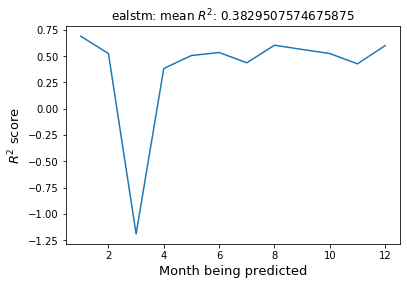

In [4]:
for model in ['ealstm']:
    plt.clf()
    plt.plot(monthly_scores['month'], monthly_scores[model])
    plt.xlabel('Month being predicted', size=13)
    plt.ylabel('$R^2$ score', size=13)
    plt.title(f'{model}: mean $R^2$: {np.mean(monthly_scores[model])}')
    plt.show()

In [24]:
def do_the_plots(pred_month, data_path):
    rnn = xr.open_dataset(data_path / f'models/one_month_forecast/ealstm/preds_2018_{pred_month}.nc')
    true = xr.open_dataset(data_path / f'features/one_month_forecast/test/2018_{pred_month}/y.nc').rename({'VHI': 'preds'}).isel(time=0)

    rnn_err = (rnn - true).preds.values
    rnn_err = rnn_err[~np.isnan(rnn_err)]
    rnn_err = np.sqrt(rnn_err ** 2).mean()
    
    print(f'For month {pred_month}, EALSTM error: {rnn_err}')
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    true.preds.plot.hist(ax=ax, label='true', histtype='stepfilled', color='r', alpha=0.3)
    rnn.preds.plot.hist(ax=ax, label='rnn', histtype='step', color='black')
    fig.legend()
    plt.show()
    
    plt.clf()
    
    fig, ax = plt.subplots(1, 2, figsize=(7, 3))
    true.preds.plot(vmin=0, vmax=100, ax=ax[0], add_colorbar=False)
    ax[0].set_title('True')
    rnn.preds.plot(vmin=0, vmax=100, ax=ax[1], add_colorbar=False)
    ax[1].set_title('EALSTM')
    plt.show()

For month 1, EALSTM error: 7.142475015812122


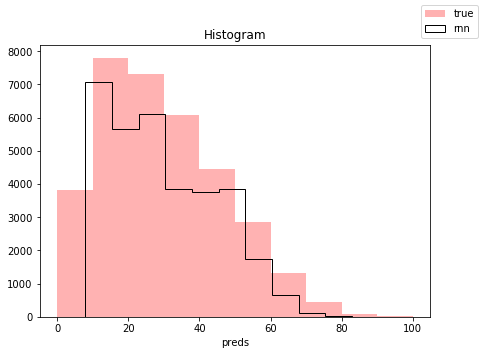

<Figure size 432x288 with 0 Axes>

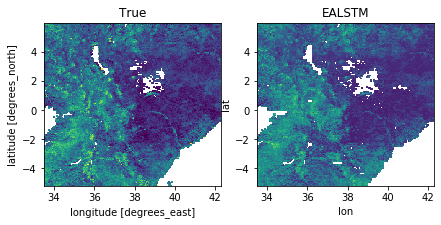

For month 2, EALSTM error: 8.612706135867178


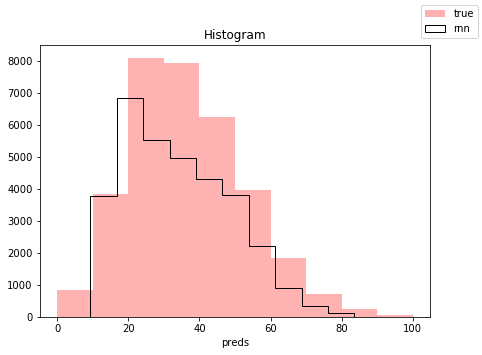

<Figure size 432x288 with 0 Axes>

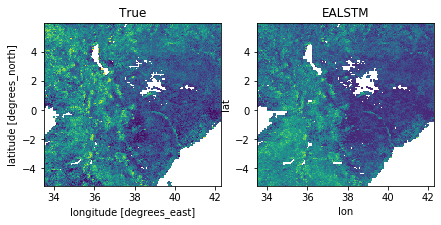

For month 3, EALSTM error: 19.653567231221835


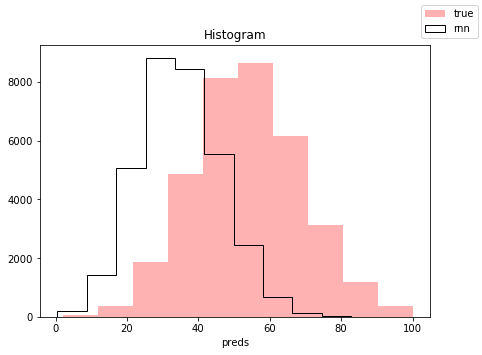

<Figure size 432x288 with 0 Axes>

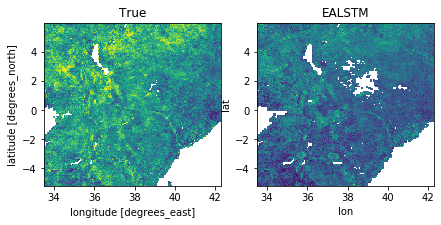

For month 4, EALSTM error: 9.255635395768381


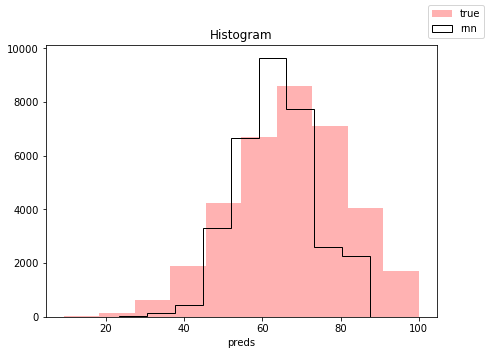

<Figure size 432x288 with 0 Axes>

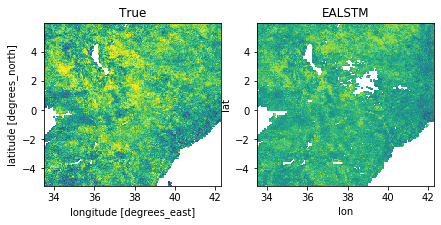

For month 5, EALSTM error: 9.006114769939192


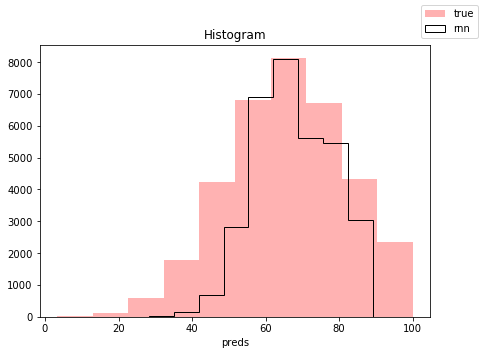

<Figure size 432x288 with 0 Axes>

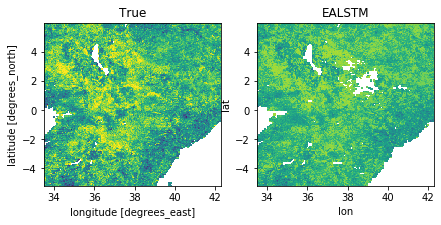

For month 6, EALSTM error: 8.746493967488972


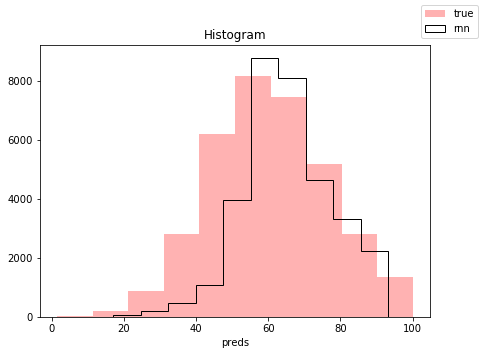

<Figure size 432x288 with 0 Axes>

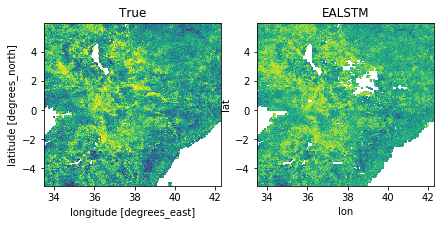

For month 7, EALSTM error: 9.693765266383009


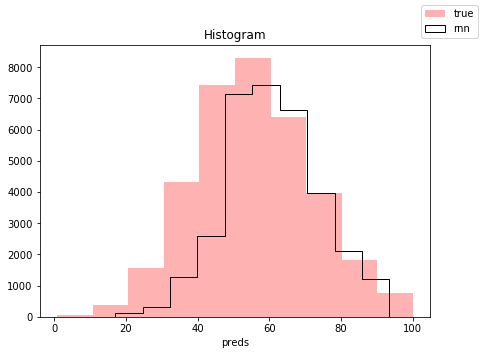

<Figure size 432x288 with 0 Axes>

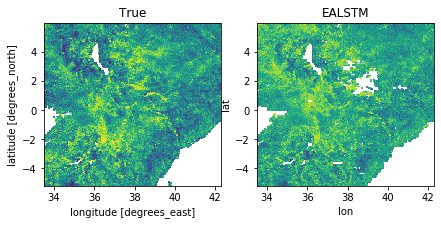

For month 8, EALSTM error: 8.585447299476659


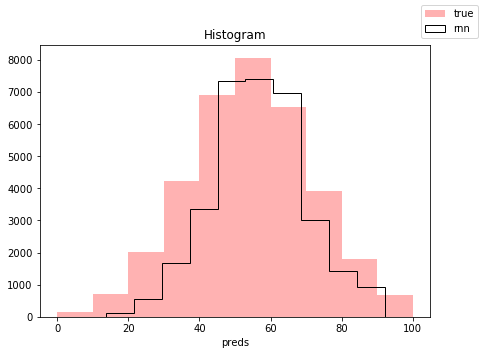

<Figure size 432x288 with 0 Axes>

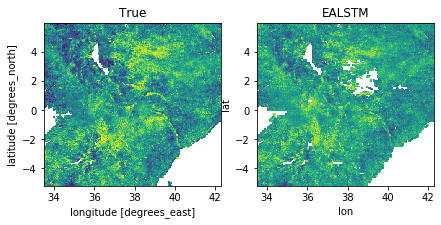

For month 9, EALSTM error: 9.044898692950127


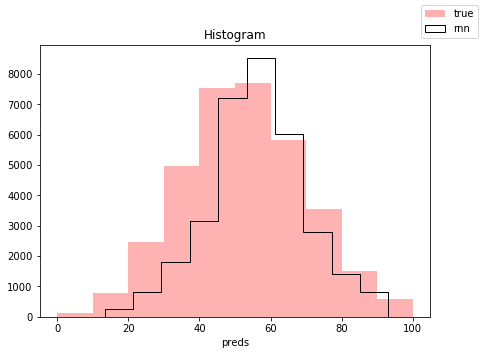

<Figure size 432x288 with 0 Axes>

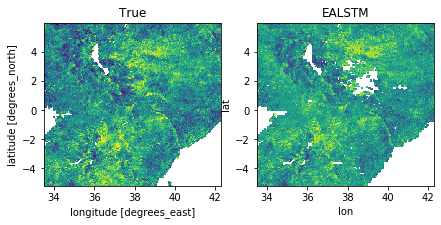

For month 10, EALSTM error: 8.690248883059995


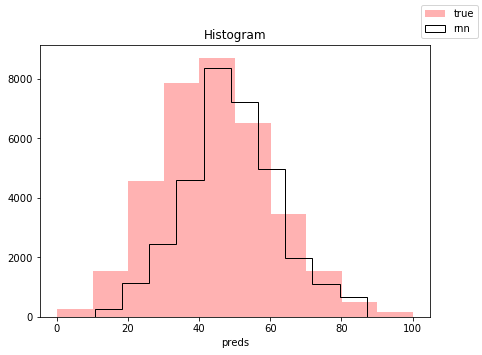

<Figure size 432x288 with 0 Axes>

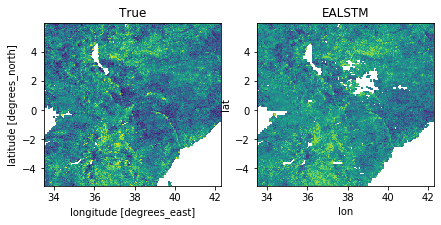

For month 11, EALSTM error: 9.446879774046854


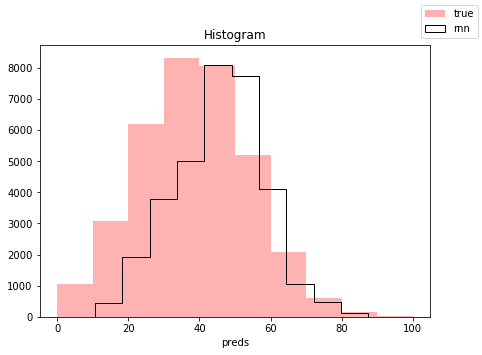

<Figure size 432x288 with 0 Axes>

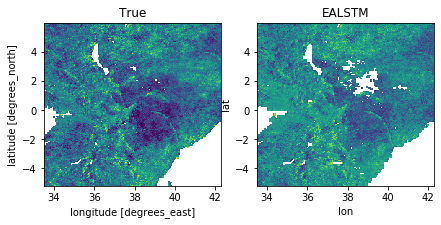

For month 12, EALSTM error: 7.61482040950016


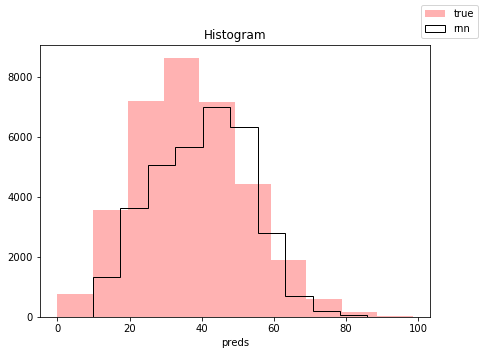

<Figure size 432x288 with 0 Axes>

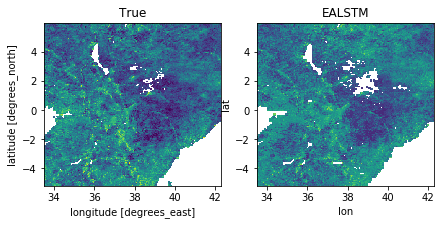

In [25]:
for i in range(1, 13):
    do_the_plots(i, data_path=data_path)

In [92]:
historical_shap = np.load('../../scripts/shap_ealstm_valie_historical.npy')
historical_input = np.load('../../scripts/shap_ealstm_input_historical.npy')

with open('../../scripts/variables_ealstm.txt') as f:
    variable_names = f.read()
    variables = variable_names[2:-2].split(',')
    # sorry this is so hacky
    variables = [var.strip().strip('"').strip('"').strip("'") for var in variables]

with (data_path / 'features/one_month_forecast/normalizing_dict.pkl').open('rb') as f:
    normalizing_dict = pickle.load(f)

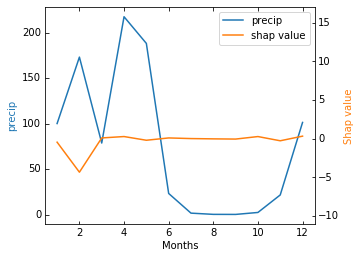

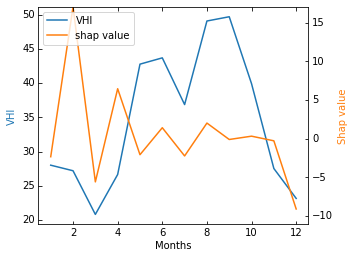

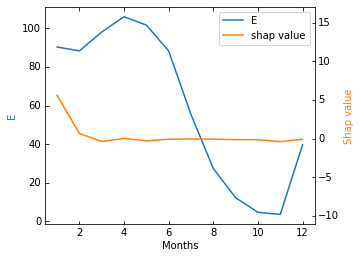

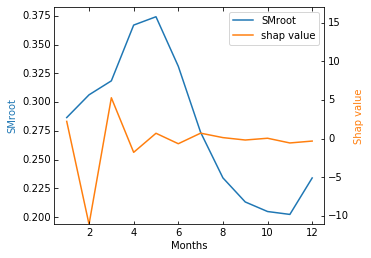

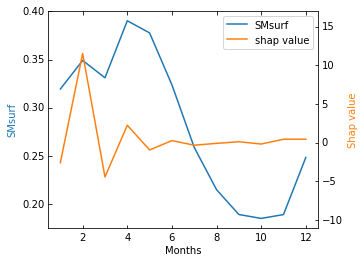

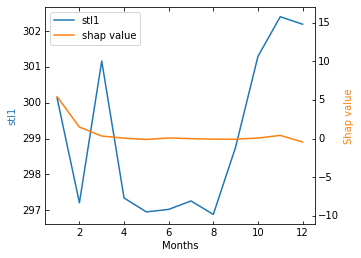

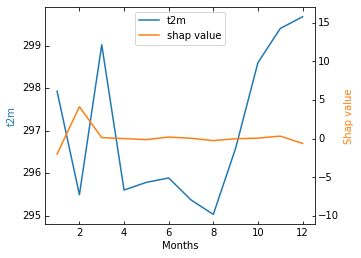

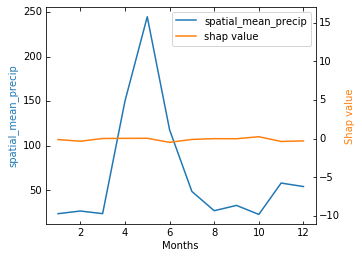

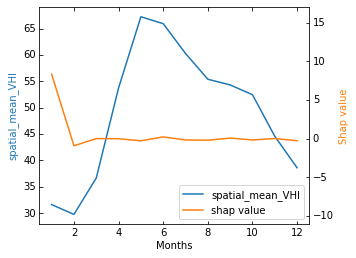

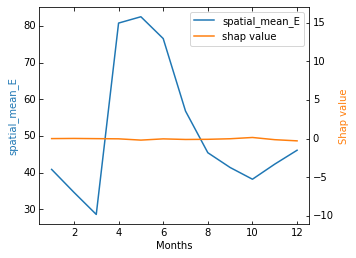

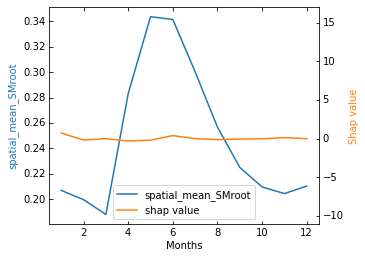

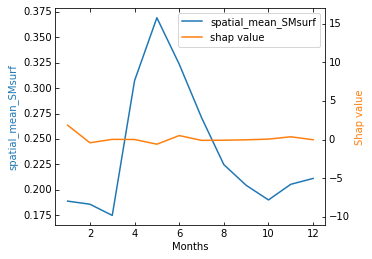

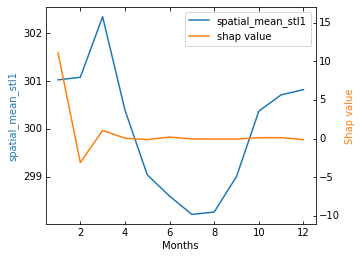

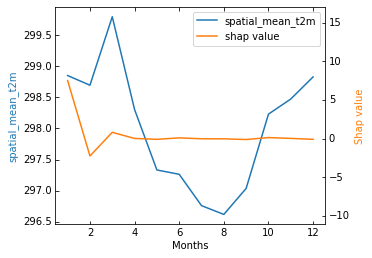

In [93]:
for variable in variables:
    plt.clf()
    plot_shap_values(historical_input[0], historical_shap[0], variables, normalizing_dict, variable,
                     normalize_shap_plots=True, show=True)
    plt.show()